<a href="https://colab.research.google.com/github/airoprojects/visiope/blob/main/experiments/test_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ai4MarsExperiments

#### Packages not included in colab

In [1]:
%pip install torchmetrics
%pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.8 MB/s eta 0:00:00


## General imports

In [2]:
# General imports

import os
import sys
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics as metrics
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import ipywidgets as widgets
from IPython.display import display

## Custom Imports

In [3]:
# Custom Imports
import sys

COLAB = 'google.colab' in sys.modules
LOCAL = not COLAB

if COLAB:

    # Clone visiope repo on runtime env
    !git clone https://github.com/airoprojects/visiope.git /content/visiope/
    %cd ./visiope/
    !git checkout main
    !git branch
    %cd ../

    # Get the root directory of the Git project
    root_dir = '/content/visiope'

    # Add custom modules to path
    custom_modules_path = root_dir + '/tools/'
    sys.path.insert(0, custom_modules_path)

elif LOCAL:

    from git import Repo

    # Initialize the Git repository object
    repo = Repo(".", search_parent_directories=True)

    # Get the root directory of the Git project
    root_dir = repo.git.rev_parse("--show-toplevel")

    # Add custom modules to path
    custom_modules_path = root_dir  + '/tools/'
    sys.path.insert(0, custom_modules_path)


# Import Loader
from data.utils import Ai4MarsDownload, Ai4MarsImporter, Ai4MarsSplitter, Ai4MarsDataLoader

# Import Loss
from loss.loss import Ai4MarsCrossEntropy, Ai4MarsDiceLoss

# Import Trainer
from trainer.trainer import Ai4MarsTrainer

# Import Tester
from tester.tester import Ai4MarsTester

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Cloning into '/content/visiope'...
remote: Enumerating objects: 1500, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 1500 (delta 20), reused 18 (delta 17), pack-reused 1444
Receiving objects: 100% (1500/1500), 225.33 MiB | 29.11 MiB/s, done.
Resolving deltas: 100% (800/800), done.
/content/visiope
Already on 'main'
Your branch is up to date with 'origin/main'.
* main
/content


## Obtain dataset

#### Selecter functions

In [4]:
# get the whole dataset
def get_d(b):

    global num_images
    global data_path
    global selector
    global X
    global y

    # Cannot select anymore
    if not selector:
        print("Cannot select multiple options")
        return
    selector = False

    # Insert here your local path to the dataset (temporary)
    data_path = input("Path to Dataset: ")

    # Insert here the number of images you want to download
    num_images = int(input("Number of images (max 1000): "))

    # Import data as Ai4MarsDataset
    Ai4MarsDownload()(PATH=data_path)
    importer = Ai4MarsImporter()
    X, y, _ = importer(PATH=data_path, NUM_IMAGES=num_images, SIZE=128)

    pass

# Enable loading chunk of data
def enable_chunk(b):

    global selector
    global CHUNK
    global current_chunk

    # Cannot select anymore
    if not selector:
        print("Cannot select multiple options")
        return
    selector = False

    CHUNK = True
    current_chunk = 0

    # Download options
    d300 = widgets.Button(description="Dataset 300")
    d500 = widgets.Button(description="Dataset 500")
    d1k = widgets.Button(description="Dataset 1000")

    # Actions
    display(d300, d500, d1k)
    d300.on_click(get_d300)
    d500.on_click(get_d500)
    d1k.on_click(get_d1k)

    pass

#### Data download funtions

In [5]:
# ge the dataset in chncks of size 300
def get_d300(b):

    global COLAB
    global CHUNK
    global dataset_type
    global current_chunk
    global chunk_size
    global total_size
    global X
    global y

    # Cannot select anymore
    if not CHUNK:
        print("Cannot select multiple options")
        return

    dataset_type = 'small-chunk-dataset/'
    chunk_size = 300
    total_size = 3000

    # update current chunk
    current_chunk += chunk_size

    print(f"Loading cunck {current_chunk // chunk_size}")

    if COLAB:

        if not(os.path.exists('/content/' + dataset_type)):

            import gdown

            # get url of torch dataset (temporarerly my drive)
            drive = 'https://drive.google.com/uc?id='
            url = 'https://drive.google.com/drive/folders/1WaQKmnty99798t6b-GMh15GVy9ZxCkGP?usp=drive_link'

            !gdown --folder {url} -O /content/

            load_data = '/content/' + dataset_type

    elif LOCAL:
        load_data = root_dir + '/datasetup/' + dataset_type

    X, y = torch.load(load_data + str(current_chunk // chunk_size) + 'dataset.pt')

    print("Done")

    pass

# ge the dataset in chncks of size 500
def get_d500(b):

    global COLAB
    global CHUNK
    global dataset_type
    global current_chunk
    global chunk_size
    global total_size
    global X
    global y

    # Cannot select anymore
    if not CHUNK:
        print("Cannot select multiple options")
        return

    dataset_type = 'medium-chunk-dataset/'
    chunk_size = 500
    total_size = 5000

    # update current chunk
    current_chunk += chunk_size

    print(f"Loading cunck {current_chunk // chunk_size}")

    if COLAB:

        if not(os.path.exists('/content/' + dataset_type)):

            import gdown

            # get url of torch dataset (temporarerly my drive)
            drive = 'https://drive.google.com/uc?id='
            url = 'https://drive.google.com/drive/folders/1u4imSO8MerdZEW0V1lkEb6PWQmZgT5Ft?usp=sharing'

            !gdown --folder {url} -O /content/

            load_data = '/content/' + dataset_type

    elif LOCAL:
        load_data = root_dir + '/datasetup/' + dataset_type

    X, y = torch.load(load_data + str(current_chunk // chunk_size) + 'dataset.pt')

    print("Done")
    pass

# ge the dataset in chncks of size 1k
def get_d1k(b):

    global COLAB
    global CHUNK
    global dataset_type
    global current_chunk
    global chunk_size
    global total_size
    global X
    global y

    # Cannot select anymore
    if not CHUNK:
        print("Cannot select multiple options")
        return

    dataset_type = 'big-chunk-dataset/'
    chunk_size = 1000
    total_size = 10000

    print(f"Loading cunck {current_chunk // chunk_size}")

    # update current chunk
    current_chunk += chunk_size

    if COLAB:

        if not(os.path.exists('/content/' + dataset_type)):

            import gdown

            # get url of torch dataset (temporarerly my drive)
            drive = 'https://drive.google.com/uc?id='
            url = 'https://drive.google.com/drive/folders/1BhL0nLbQt930l_ISDgUS8ZJRWGjH4eUU?usp=sharing'

            !gdown --folder {url} -O /content/

            load_data = '/content/' + dataset_type

    elif LOCAL:
        load_data = root_dir + '/datasetup/' + dataset_type

    X, y = torch.load(load_data + 'dataset_' + str(current_chunk) + '.pt')

    pass

#### Selector

In [6]:
# Select import mode

# ENV VARIABLE INITIALIZATION DO NOT CHANGE
dataset_type = ''
CHUNK = False
current_chunk = 0
chunk_size = 0
total_size = 0
X = 0
y = 0

# Allow to select only one option
if 'selector' not in globals():
    selector  = True

# Selection buttons
d = widgets.Button(description="Load whole Dataset")
chunk = widgets.Button(description="Load chunk of data")

# actions
display(d, chunk)
d.on_click(get_d)
chunk.on_click(enable_chunk)


Button(description='Load whole Dataset', style=ButtonStyle())

Button(description='Load chunk of data', style=ButtonStyle())

Button(description='Dataset 300', style=ButtonStyle())

Button(description='Dataset 500', style=ButtonStyle())

Button(description='Dataset 1000', style=ButtonStyle())

Loading cunck 1
Retrieving folder list
Processing file 1L-PEPTaf69-GY328jywdnix6PanNFPA3 1dataset.pt
Processing file 1JvWa9C8wH5wiopxbscAiXiCR1MwQIKiA 2dataset.pt
Processing file 1lO1fAAY8q7Tnra30s4Apuozi1yn25142 3dataset.pt
Processing file 1ENfwUJnJtEDJG-aNEdVidtFD7vwQPG51 4dataset.pt
Processing file 1HBU0xE1z3EfWjjhaIgy3VK74EhCznQdz 5dataset.pt
Processing file 1csls580x9DAmxjAMgss3YBvVH5HLNJpr 6dataset.pt
Processing file 1CK8sywP4sjm1GLXC7yL1WEhbaXT8Yzhg 7dataset.pt
Processing file 1vX4fRklv7vYGBzaNNjvASiCZs-hzrb8g 8dataset.pt
Processing file 1BoF3cE0xFBtXKmee1U7ld7XuZoX3sD08 9dataset.pt
Processing file 17KBMswJLsAhzGzaXiptpQre5Qh1W56_J 10dataset.pt
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1L-PEPTaf69-GY328jywdnix6PanNFPA3
To: /content/medium-chunk-dataset/1dataset.pt
100% 170M/170M [00:00<00:00, 272MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JvWa9C8wH5wiopxb

In [ ]:
# HARD RESET
# selector = True
# CHUNK = False

## DataLoader

In [7]:
transform = None
# Uncomment the following lines to apply transformations to the dataset
'''
transform = transforms.RandomChoice([
    transforms.RandomRotation(90)])
'''

# Split the dataset
splitter = Ai4MarsSplitter()
percentages = [0.7, 0.2, 0.1]
train_set, test_set, val_set = splitter(X, y, percentages, transform=transform)

# Load info
load_info = './.info.pt'
info = torch.load(load_info)

# Build Ai4MarsDataloader
loader = Ai4MarsDataLoader()
batch_sizes = [32, 16, 16]
datasets = [train_set, test_set, val_set]
train_loader, test_loader, val_loader = loader(datasets, batch_sizes)

Splitting parameters: 
             Dataset: ai4mars-dataset-merged-0.1 
             Colab environment: True 
             Split percentages: [0.7, 0.2, 0.1] 
             Transformation: None 
             Svaving path: None 
             New image size: 128
Extrapolation of random inices ...
Splitting in progress ...
Done 

Building Dataloaders
Done 



Len of train set: 560
Len of test set: 160
Len of validation set: 80
image shape: torch.Size([128, 128, 3])


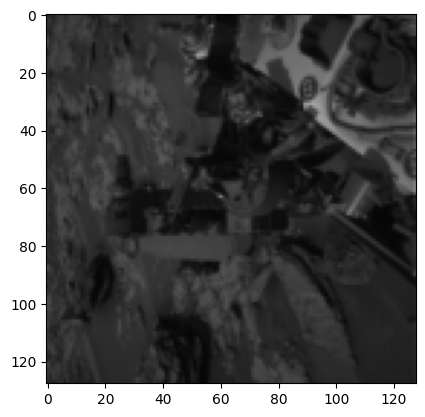

image shape: torch.Size([128, 128, 1])


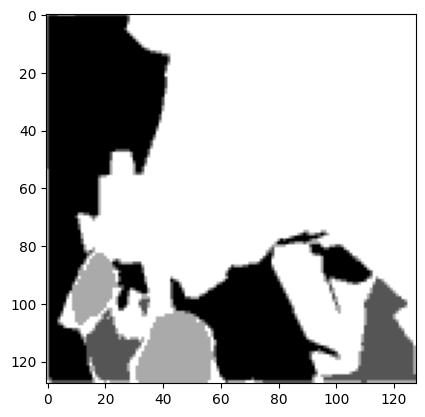

In [8]:
# Just to check that different chunks contains different images
import matplotlib.pyplot as plt

print(f'Len of train set: {len(train_set)}')
print(f'Len of test set: {len(test_set)}')
print(f'Len of validation set: {len(val_set)}')

image, label = X[0], y[0]

print(f'image shape: {image.permute(1,0,2).permute(0,2,1).shape}')
plt.imshow(image.permute(1,0,2).permute(0,2,1).detach().numpy(), cmap='gray')
plt.show()

print(f'image shape: {label.permute(1,0,2).permute(0,2,1).shape}')
plt.imshow(label.permute(1,0,2).permute(0,2,1).detach().numpy(), cmap='gray')
plt.show()

# Free up mem
del X
del y

## Model setup

In [9]:
# Clone remote repo with existing models

if COLAB:
    !git clone https://github.com/sithu31296/semantic-segmentation
    %pip install -e .
    %pip install -U gdown
    %cd semantic-segmentation

Cloning into 'semantic-segmentation'...
remote: Enumerating objects: 792, done.
remote: Counting objects: 100% (789/789), done.
remote: Compressing objects: 100% (312/312), done.
remote: Total 792 (delta 479), reused 749 (delta 470), pack-reused 3
Receiving objects: 100% (792/792), 54.99 MiB | 35.59 MiB/s, done.
Resolving deltas: 100% (479/479), done.
Obtaining file:///content/semantic-segmentation
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61405 sha256=3acaa4fdfc63345248a8cfd4fc100497b8bc227f6630a42226679a3ab155aff2
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42

In [10]:
from semseg import show_models

show_models()

  No.  Model Names
-----  -------------
    1  SegFormer
    2  Lawin
    3  SFNet
    4  BiSeNetv1
    5  DDRNet
    6  FCHarDNet
    7  BiSeNetv2


In [11]:
#  Import segformer

from semseg.models import *

model = eval('Lawin')(
    backbone='MiT-B2',
    num_classes=5
)

try:
    model.load_state_dict(torch.load('checkpoints/pretrained/segformer/segformer.b2.ade.pth',
                                     map_location=device))
    print("Pretrained model's weights downloaded")
except:
    print("Download a pretrained model's weights from the result table.")

model.to(device)

print('Loaded Model')
%cd /content/

Download a pretrained model's weights from the result table.
Loaded Model
/content


## Training

#### Training parameters

In [ ]:
# test different cross entropy
class TestCE(nn.Module):
    def __init__(self,
                 ignore_label: int = 4,
                 weight = None) -> None:
        super().__init__()
        self.ignore_index = ignore_label
        self.weight = weight

    def forward(self, inputs, target):

        # Cross entropy needs inputs in original shape B x C x H x W but we have B x H x W x C
        rev_inputs = inputs.permute(0, 1, 3, 2).permute(0, 2, 1, 3)

        # Create the labels one hot tensor
        num_classes = inputs.shape[1]
        target_one_hot = F.one_hot(target, num_classes=num_classes)

        criterion = nn.CrossEntropyLoss(self.weight) #, self.ignore_index=ignore_label)

        return criterion(rev_inputs, target)

In [17]:
class TestDice(nn.Module):
    def __init__(self, delta: float = 0.5, aux_weights: list = [1, 0.4, 0.4]):
        """
        delta: Controls weight given to FP and FN. This equals to dice score when delta=0.5
        """
        super().__init__()
        self.delta = delta
        self.aux_weights = aux_weights

    def _forward(self, preds, labels):
        # preds in shape [B, C, H, W] and labels in shape [B, H, W]
        preds = preds.permute(0, 1, 3, 2).permute(0, 2, 1, 3)
        num_classes = preds.shape[1]
        preds = F.softmax(preds, dim=1)
        labels = F.one_hot(labels, num_classes).permute(0, 3, 1, 2)
        tp = torch.sum(labels*preds, dim=(2, 3))
        fn = torch.sum(labels*(1-preds), dim=(2, 3))
        fp = torch.sum((1-labels)*preds, dim=(2, 3))

        dice_score = (tp + 1e-6) / (tp + self.delta * fn + (1 - self.delta) * fp + 1e-6)
        dice_score = torch.sum(1 - dice_score, dim=-1)

        dice_score = dice_score / num_classes
        return dice_score.mean()

    def forward(self, preds, targets):
        if isinstance(preds, tuple):
            return sum([w * self._forward(pred, targets) for (pred, w) in zip(preds, self.aux_weights)])
        return self._forward(preds, targets)

In [13]:
# Training parameters

loss_fn = Ai4MarsDiceLoss().to(device)
#loss_fn = TestDice().to(device)
# loss_fn = Ai4MarsCrossEntropy().to(device)
# loss_fn = TestCE().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
optimizer = torch.optim.Adam([
                {'params': model.backbone.parameters(), 'lr': 1e-3},
                {'params': model.decode_head.parameters(), 'lr': 1e-4}
                ]
                            ,amsgrad = True)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)

transform = None
# transform = transforms.RandomChoice([
#      transforms.RandomRotation(90)])

epochs = 5

trainer = Ai4MarsTrainer(loss_fn, optimizer, train_loader, val_loader, lr_scheduler=lr_scheduler,
                         transform=transform, device=device, info=info, model_name='Lawin-MiT-B2', dump=True)

In [ ]:
# Model Parameters
# Check if the variable has been defined
if 'run_once' not in globals():
    run_once = True
    trainer.param_hist(model, label='before')

#### Regular training

In [14]:
# Start training
trainer.train_multiple_epoch(model, EPOCHS=epochs)

EPOCH 1
Train loss: 0.7295715378390418
Time needed for training: 59.079649209976196 seconds
Validation loss: 0.6217698097229004 

EPOCH 2
Train loss: 0.6356240842077467
Time needed for training: 54.14195275306702 seconds
Validation loss: 0.7517432808876038 

EPOCH 3
Train loss: 0.6197545693980323
Time needed for training: 53.18868327140808 seconds
Validation loss: 0.7695329427719116 

EPOCH 4
Train loss: 0.6134474509292178
Time needed for training: 51.72295045852661 seconds
Validation loss: 0.5694825172424316 

EPOCH 5
Train loss: 0.5995605124367608
Time needed for training: 51.73819541931152 seconds
Validation loss: 0.5696380615234375 



#### Chunk training

In [ ]:
if not CHUNK:
    print("You are not allowd to perform chunk training proceede with regular traiing")

else:

    print("You are allowd to perform chunk training proceede with regular traiing")
    print("Please pay attention that you are using the same splitting parameters")

    CHUNK = False
    stop_at = 5 #(total_size // chunk_size)

    for i in range(0, stop_at):

        if i == 0:
            print(f"Loading chunck {current_chunk // chunk_size}")
            trainer.train_multiple_epoch(model, EPOCHS=epochs)
            trainer.plot_loss()

        else:

            # update current chunk
            current_chunk += chunk_size

            print(f"Loading chunck {current_chunk // chunk_size}")

            if COLAB: load_data = '/content/' + dataset_type
            elif LOCAL: load_data = root_dir + '/datasetup/' + dataset_type

            X, y = torch.load(load_data + str(current_chunk // chunk_size) + 'dataset.pt')

            # Build dataset
            splitter = Ai4MarsSplitter()
            train_set, test_set, val_set = splitter(X, y, percentages)

            # Build Ai4MarsDataloader
            loader = Ai4MarsDataLoader()
            train_loader, test_loader, val_loader = loader(
                [train_set, test_set, val_set], batch_sizes)

            trainer.train_multiple_epoch(model, EPOCHS=epochs)
            trainer.plot_loss()

In [27]:
# Hard reset
CHUNK = True
current_chunk = 500

#### Plot loss

Data will be saved in ./dump/20230719-111010-Lawin-MiT-B2/loss/


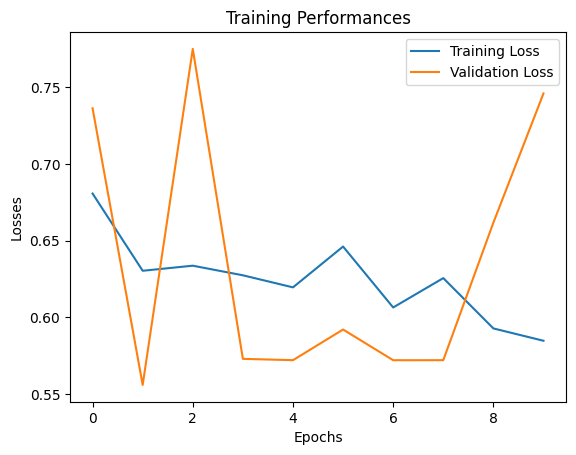

Train mean loss: 0.6246860560443667
Validation mean loss: 0.6355649828910828


In [16]:
# Plot loss

import matplotlib.pyplot as plt

trainer.plot_loss()

## Testing

In [22]:
# # Testing and evaluation Metrics
class Ai4MarsTester():

    def __init__(self, loss_fn, metric, test_loader=None, device='cpu') -> None:
        self.loss_fn = loss_fn
        self.metric = metric
        self.test_loader = test_loader
        self.device  = device
        pass

    def test_one_epoch(self, model):
        running_loss = 0.
        last_loss = 0.
        total_outputs = []
        total_labels = []

        for batch_index, batch in enumerate(self.test_loader):

            # Inputs labes pair
            inputs, labels = batch

            # Send Tensors to device
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            outputs = model(inputs)

            # New shape: B x W x H x C
            outputs = outputs.permute(0,2,1,3).permute(0,1,3,2)

            labels = labels.squeeze()
            labels = labels.long()

            # Accumulate inputs labels to compute metrics
            total_outputs.append(outputs)
            total_labels.append(labels)

            loss = self.loss_fn(outputs, labels)
            running_loss += loss.item()

            # Free up RAM/VRAM
            inputs.detach()
            labels.detach()
            del inputs
            del labels
            torch.cuda.empty_cache()

        # Compute average loss over all batches
        last_loss = (running_loss) / (batch_index + 1 )

        print(f"Test loss: {last_loss}\n")

        # Preprocessing for metrics computation
        if len(self.test_loader.dataset) % self.test_loader.batch_size != 0:
            total_outputs.pop(-1)
            total_labels.pop(-1)

        total_outputs = torch.stack(total_outputs, dim=0)
        total_labels = torch.stack(total_labels, dim=0)

        total_outputs = F.softmax(total_outputs, dim=-1)
        total_labels = F.one_hot(total_labels, num_classes=total_outputs.shape[-1])

        # Index metrics
        value = self.metric(total_outputs.reshape(-1), total_labels.reshape(-1))

        print(f"Metrics {self.metric}: {value.item()}")


metric = metrics.JaccardIndex(task="multiclass", num_classes=5).to(device)
tester = Ai4MarsTester(loss_fn, metric, test_loader, device=device)

In [ ]:
# Start testing
torch.cuda.empty_cache()
tester.test_one_epoch(model)
# print(test_loader.dataset.__getitem__(0)[0].shape)

In [ ]:
# Module Parameters
trainer.param_hist(model, label='after')

In [ ]:
model.eval()

for i, batch in enumerate(test_loader):
  image, label = batch
  print(image.shape)
  model = model.cpu()
  pred = model(image)
  tester.show_images(image, trainer.results_path, index=i)
  tester.show_seg(label, trainer.results_path, index=i)
  tester.show_seg(pred.cpu(), trainer.results_path, index=i)

In [34]:
# To save file once you trained
!zip -r 20230719-103133-Lawin-MiT-B2.zip /content/dump/20230719-103133-Lawin-MiT-B2
from google.colab import files

#files to save
files.download("20230719-103133-Lawin-MiT-B2.zip")

  adding: content/dump/20230719-103133-Lawin-MiT-B2/ (stored 0%)
  adding: content/dump/20230719-103133-Lawin-MiT-B2/model_state/ (stored 0%)
  adding: content/dump/20230719-103133-Lawin-MiT-B2/model_state/config (deflated 21%)
  adding: content/dump/20230719-103133-Lawin-MiT-B2/loss/ (stored 0%)
  adding: content/dump/20230719-103133-Lawin-MiT-B2/loss/loss_plot_20230719_104329.png (deflated 7%)
  adding: content/dump/20230719-103133-Lawin-MiT-B2/loss/loss_plot_20230719_104709.png (deflated 7%)
  adding: content/dump/20230719-103133-Lawin-MiT-B2/loss/loss_plot_20230719_103607.png (deflated 6%)
  adding: content/dump/20230719-103133-Lawin-MiT-B2/loss/loss_plot_20230719_105051.png (deflated 6%)
  adding: content/dump/20230719-103133-Lawin-MiT-B2/loss/loss_plot_20230719_103946.png (deflated 7%)
  adding: content/dump/20230719-103133-Lawin-MiT-B2/images/ (stored 0%)
  adding: content/dump/20230719-103133-Lawin-MiT-B2/images/image3.png (deflated 1%)
  adding: content/dump/20230719-103133-La

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>